## 1 - Importer les librairies <a class="anchor" id="chapter1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn import decomposition
from sklearn import preprocessing
from functions import *
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import scipy.stats as stats
from scipy import stats
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from sklearn.preprocessing  import LabelEncoder
from sklearn.preprocessing  import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, confusion_matrix,accuracy_score,classification_report
from sklearn import metrics
from sklearn.pipeline import Pipeline

from functions import *
from time import time

import warnings
warnings.filterwarnings('ignore')

# Sommaire :

**<a href="#A1"> 1. Prétraitement de données</a>**
- <a href="#C1">1.1. Description du jeu de données</a>
- <a href="#C2">1.2. Traitement des valeurs manquantes</a>
- <a href="#C3">1.3. Analyse descriptive des variables </a>


**<a href="#A2"> 2. Le clustering par le K-means avec les données brutes</a>**
- <a href="#C4">2.1. Préparation de données</a>
- <a href="#C6">2.2. Implémentation du Kmeans sur la base train </a>  
- <a href="#C7">2.3. Evaluation du modèle </a>

**<a href="#A3"> 3. Le clustering par la regression logistique</a>**
- <a href="#C8">3.1. Préparation de données</a>
- <a href="#C9">3.2. Implémentation da la regression logistique sur la base train </a>
- <a href="#C10">3.3. Evaluation du modèle </a>

**<a href="#A4"> 4. Choix du modèle</a>**

**<a href="#A5"> 5. Application de détection de vrais et faux billets</a>**

##  <a name="A1"> 1. Prétraitement de données

##  <a name="C1"> 1.1. Description du jeu de données

##### Importer les données

In [2]:
dataBillets=pd.read_csv('C:/Users/33768/Documents/DataSets/Projet 10/billets.csv', sep=';',encoding='UTF-8')

##### Afficher les 5 premières lignes pour s assurer que les données ont été chargées correctement

In [3]:
dataBillets.head(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [4]:
#dataBillets.query('margin_low>9')

##### Afficher la dimension du dataframe

In [5]:
dataBillets.shape

(1500, 7)

##### Vérifier le typage de données

In [6]:
dataBillets.dtypes

is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

#### Rechercher les outliers

In [7]:
dataBillets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Tout semble normal. Pas d'outliers.

##### Vérifier les valeurs manquantes (NaN)

In [8]:
dataBillets.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

37 valeurs manquantes à imputer par la regression linéaire. 

##  <a name="C2"> 1.2. Traitement des valeurs manquantes </a>

Nous imputerons les valeurs manquantes avec la regression linéaire. Notre variable cible est margin_low. Les autres variables sont les variables explicatives.
Le dataframe est scindé en 2. D'un côté, nous avons les données avec valeurs manquantes et de l'autre, les données avec valeurs manquantes.

### 1.2.1. Etude de la corrélation des variables

#### Matrice de corrélation

Text(0.5, 1.0, 'Matrice des correlations\n')

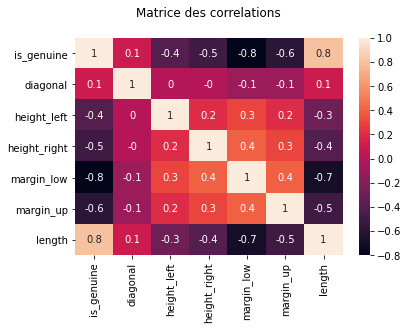

In [9]:
matrice_corr = dataBillets.corr().round(1)
sns.heatmap(data=matrice_corr, annot=True)
plt.title("Matrice des correlations\n")

Corrélations observées sur la variable à prédire :

length est fortement correlée  (r=0.7)avec la variable margin_low. 
is_genuime est fortement correlée  (r=0.8)avec la variable margin_low.
margin_up,height_right et height_left sont correlés à margin_low avec r >=4.
diagonal étant faiblement correlé (r=0.1) à margin_low, nous le supprimons de notre analyse.
Les variables length, margin_up sont fortement correlées à is_genuime. les couples is_genuime,length  et is_genuime, margin_up rapportent la même information. De ce fait, nous supprimons donc la variable is_genuime. 

### 1.2.2. Regression Linéaire (statsmodel)

#### Préparer les données

In [10]:
# Copie des données
data = dataBillets.copy()

# Remplacer les valeurs True, False par 0,1
data["is_genuine"].replace([True, False],[1,0], inplace=True)

# Retirer les lignes avec NAN du dataset et stocker dans un dataframe
dataBillets_na = data[data['margin_low'].isna()] 
data.dropna(inplace=True)

# Vérifier que les lignes avec valeurs manquantes ont été supprimées du dataframe
print(data.isna().sum())

# Supprimer la colonne is_genuine du dataset sans NAN
data_reg=data.drop(columns=['is_genuine'])
data_reg

# Supprimer la colonne diagonal du dataset sans NAN
data_reg=data_reg.drop(columns=['diagonal'])
data_reg

# Supprimer la colonne is_genuine du dataset avec NAN
dataBillets_na_Reg=dataBillets_na.drop(columns=['is_genuine'])
dataBillets_na_Reg

# Supprimer la colonne diagonal du dataset avec NAN
dataBillets_na_Reg=dataBillets_na_Reg.drop(columns=['diagonal'])
dataBillets_na_Reg

# Supprimer la colonne diagonal du dataset avec NAN
dataBillets_na_Reg=dataBillets_na_Reg.drop(columns=['margin_low'])
dataBillets_na_Reg

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64


,height_left,height_right,margin_up,length
72,103.89,103.45,3.25,112.79
99,104.07,104.18,3.14,113.08
151,103.80,104.38,3.02,112.93
197,103.66,103.80,3.62,113.27
241,104.14,104.06,3.02,112.36
251,103.26,102.82,2.95,113.22
284,103.83,103.76,3.23,113.29
334,103.70,103.96,3.00,113.36
410,103.72,103.51,3.12,112.95
413,103.66,103.50,3.16,112.95


Nous avons maintenant deux datasets. Un avec les lignes avec NAN et l'autre sans NAN. 

Nous supprimerons la variable is_genuine de notre regression linéaire.

#### Définition des variables explicatives et expliquées (X et Y)

In [11]:
X=data_reg[['length','margin_up','height_right','height_left']]
Y=data_reg['margin_low']

#### Split des données en base Train et Test

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)  # Train 80% et Test 20%
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1170, 4)
(293, 4)
(1170,)
(293,)


#### Implémentation de la regression linéaire sur la base Train

In [13]:
X_train = sm.add_constant(X_train)

# Implémentation du modèle et entrainement
model_reg_multi = sm.OLS(Y_train, X_train).fit()

# Entrainement du modèle
#result=model_reg_multi

print(model_reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     270.1
Date:                Thu, 01 Sep 2022   Prob (F-statistic):          2.93e-164
Time:                        12:17:50   Log-Likelihood:                -781.09
No. Observations:                1170   AIC:                             1572.
Df Residuals:                    1165   BIC:                             1598.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.0438      7.754      0.522   

On constate que certains coefficients ne pas significatifs car pas différent de 0 car leur P-value est supérieure à 0,05%. Le R2 est de 48,1% et le R2 ajusté est de 47,9%. 

Notre modèle explique seulement 48,1% de la variation de notre variable dépendante margin_low. Il n'a pas un bon score car contient des variables non significatives. Il n'est pas bon. Nous supprimerons le coefficient cont qui n'est pas significatif.

#### Suppression de la colonne const non significative

In [14]:
X_train=X_train.drop(columns=['const'])
X_train

,length,margin_up,height_right,height_left
448,113.16,3.34,103.69,103.93
821,113.60,3.00,103.94,104.04
1396,112.28,3.34,104.23,104.53
1308,112.13,3.40,104.32,104.02
1004,111.72,3.13,104.23,104.25
...,...,...,...,...
1461,112.75,3.33,104.31,104.66
1173,111.82,3.18,104.31,104.38
1027,111.28,3.28,104.66,104.02
210,113.40,2.95,103.66,103.76


#### Nouvelle implémentation de la regression linéaire sans consttante

In [15]:
#X_train = sm.add_constant(X_train)

# Création et entrainement du modèle
model_reg_multi = sm.OLS(Y_train, X_train).fit()

print(model_reg_multi.summary())

                                 OLS Regression Results                                
Dep. Variable:             margin_low   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                          2.655e+04
Date:                Thu, 01 Sep 2022   Prob (F-statistic):                        0.00
Time:                        12:17:50   Log-Likelihood:                         -781.23
No. Observations:                1170   AIC:                                      1570.
Df Residuals:                    1166   BIC:                                      1591.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

#### Prédiction de margin-low sur les données Test

In [16]:
model_reg_multi.predict(X_test)

544     4.048706
472     4.135051
806     4.269085
680     4.104053
670     4.386674
          ...   
559     4.108159
295     4.460639
613     4.424933
1021    5.141796
1162    5.414124
Length: 293, dtype: float64

#### Prédiction des valeurs de margin_low dans le dataset avec les données NAN

In [17]:
#dataBillets_na_Reg["margin_low"] = model_reg_multi.predict(dataBillets_na_Reg)

#dataBilletsAvecNANSansGeniume['margin_low']=results.predict(dataBilletsAvecNANSansGeniumeMarginLow)

#data["margin_low"][data["margin_low"].isnull()] = predict_na2


#### Supprimer la colonne is_genuine du dataset avec des lignes NAN

In [18]:
dataBillets_na_margin=dataBillets_na[['height_left','height_right','margin_up','length','margin_low']]
dataBillets_na_margin

,height_left,height_right,margin_up,length,margin_low
72,103.89,103.45,3.25,112.79,NaN
99,104.07,104.18,3.14,113.08,NaN
151,103.80,104.38,3.02,112.93,NaN
197,103.66,103.80,3.62,113.27,NaN
241,104.14,104.06,3.02,112.36,NaN
251,103.26,102.82,2.95,113.22,NaN
284,103.83,103.76,3.23,113.29,NaN
334,103.70,103.96,3.00,113.36,NaN
410,103.72,103.51,3.12,112.95,NaN
413,103.66,103.50,3.16,112.95,NaN


#### Prédiction et imputation des valeurs de margin_low dans le dataset avec les lignes NAN

In [19]:
dataBillets_na_margin['margin_low']=model_reg_multi.predict(dataBillets_na_Reg)  # appliquer aux données manquantes
dataBillets_na_margin

#dataBillets_na_Reg['margin_low']=model_reg_multi.predict(dataBillets_na_margin)  # appliquer aux données manquantes

,height_left,height_right,margin_up,length,margin_low
72,103.89,103.45,3.25,112.79,10.534832
99,104.07,104.18,3.14,113.08,10.693069
151,103.80,104.38,3.02,112.93,10.794129
197,103.66,103.80,3.62,113.27,10.920363
241,104.14,104.06,3.02,112.36,10.452974
251,103.26,102.82,2.95,113.22,10.622655
284,103.83,103.76,3.23,113.29,10.740939
334,103.70,103.96,3.00,113.36,10.801183
410,103.72,103.51,3.12,112.95,10.617697
413,103.66,103.50,3.16,112.95,10.649766


#### Equation de regresseion linéaire

margin_low = -0.4024 x lengh + 0.2752 x margin_up + 0.2669 x height_right + 0.2040 x height_left

#### Remplacer les valeurs manquantes par les valeurs prédites avec la regression linéaire  <a class="anchor" id="chapter9"></a>

margin_low = -0.4024 x lengh + 0.2752 x margin_up + 0.2669 x height_right + 0.2040 x height_left

In [20]:
dataBillets_na['margin_low']= -0.4024*dataBillets_na['length'] + 0.2752*dataBillets_na['margin_up']+ 0.2669*dataBillets_na['height_right'] + 0.2040*dataBillets_na['height_left']
dataBillets_na

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,1,171.94,103.89,103.45,4.312069,3.25,112.79
99,1,171.93,104.07,104.18,4.396658,3.14,113.08
151,1,172.07,103.80,104.38,4.422294,3.02,112.93
197,1,171.45,103.66,103.80,4.267236,3.62,113.27
241,1,171.83,104.14,104.06,4.635614,3.02,112.36
251,1,171.80,103.26,102.82,3.759810,2.95,113.22
284,1,171.92,103.83,103.76,4.175864,3.23,113.29
334,1,171.85,103.70,103.96,4.111260,3.00,113.36
410,1,172.56,103.72,103.51,4.193243,3.12,112.95
413,1,172.30,103.66,103.50,4.189342,3.16,112.95


#### Appliquer la prédiction de margin_low dans le dataset initial

In [21]:
dataBillets["margin_low"][dataBillets["margin_low"].isnull()] = model_reg_multi.predict(dataBillets_na[['length','margin_up','height_right','height_left']])
#dataBillets.query('margin_low>6')
dataBillets["is_genuine"].replace([True, False],[1,0], inplace=True)
dataBillets

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,0,171.75,104.38,104.17,4.42,3.09,111.28
1496,0,172.19,104.63,104.44,5.27,3.37,110.97
1497,0,171.80,104.01,104.12,5.51,3.36,111.95
1498,0,172.06,104.28,104.06,5.17,3.46,112.25


#### Vérifier que les lignes avec valeurs manquantes ont été supprimées du dataframe

In [22]:
dataBillets.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

Pas de données manquantes après l'imputation des valeurs dans margin_low.

In [23]:
#data=pd.concat([dataBillets_na,data], ignore_index=True)
#data

## <a name="C3">1.3. Analyse descriptive des variables</a> 

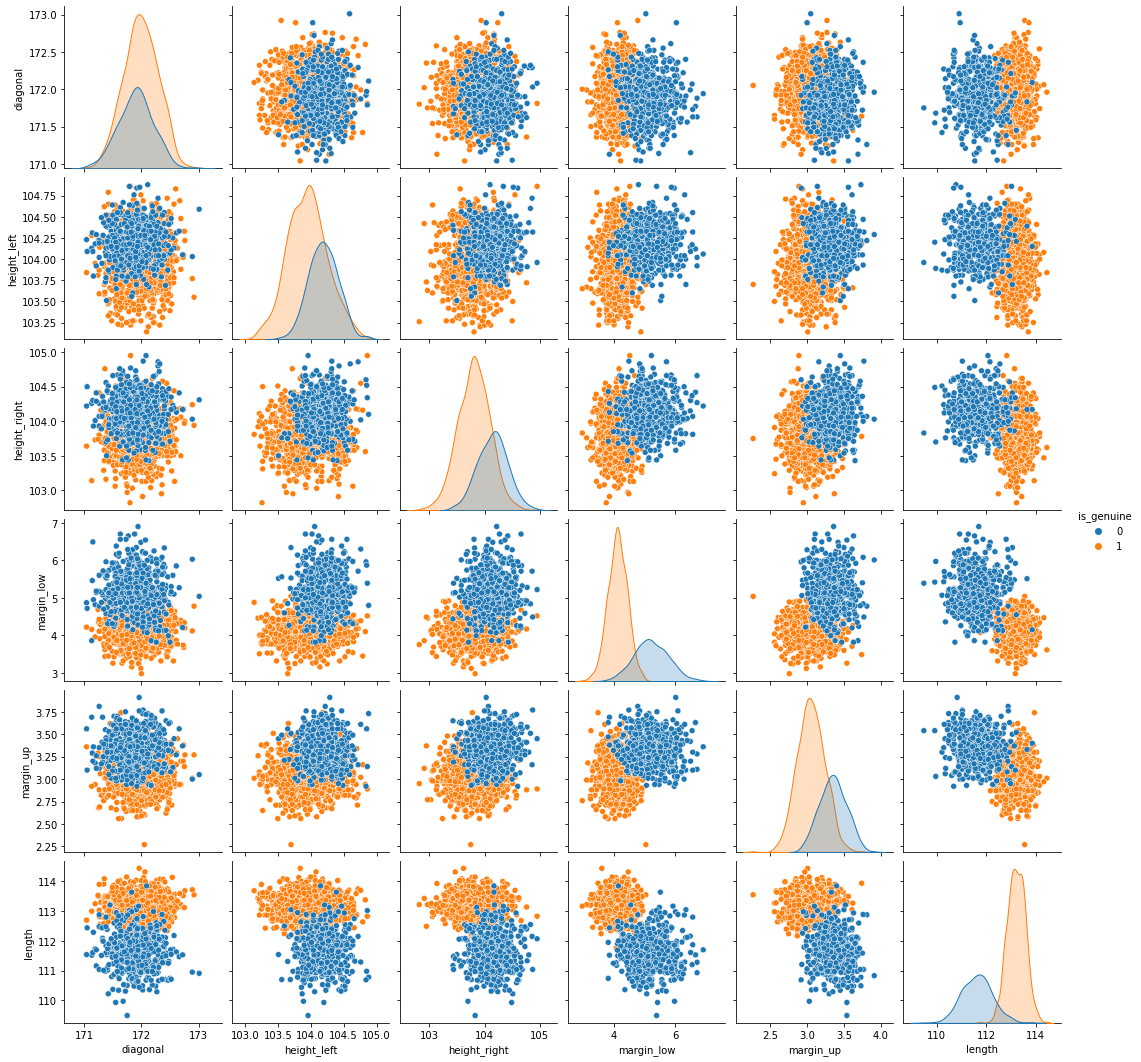

In [24]:
sns.pairplot(dataBillets, hue="is_genuine")

Aucune variable ne permet de sépararer à 100% les vrais des faux billets. Cependant les variables margin_low et length permettent de séparer les deux dans certains cas. 

##  <a name="A2"> 2. Le clustering par le K-means avec les données brutes

## <a name="C4">2.1. Préparation des données</a> 

#### Création des individus dans le dataframme

In [25]:
dataBillets = dataBillets.assign(Individu=[1 + i for i in range(len(dataBillets))])
dataBillets

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,Individu
0,1,171.81,104.86,104.95,4.52,2.89,112.83,1
1,1,171.46,103.36,103.66,3.77,2.99,113.09,2
2,1,172.69,104.48,103.50,4.40,2.94,113.16,3
3,1,171.36,103.91,103.94,3.62,3.01,113.51,4
4,1,171.73,104.28,103.46,4.04,3.48,112.54,5
...,...,...,...,...,...,...,...,...
1495,0,171.75,104.38,104.17,4.42,3.09,111.28,1496
1496,0,172.19,104.63,104.44,5.27,3.37,110.97,1497
1497,0,171.80,104.01,104.12,5.51,3.36,111.95,1498
1498,0,172.06,104.28,104.06,5.17,3.46,112.25,1499


#### Définir des variables explicatives et expliquées (X et Y)

In [26]:
dataBillets["is_genuine"] = dataBillets["is_genuine"].astype('category')
Y = dataBillets["is_genuine"].cat.codes
# on ne prend que les colonnes quantitatives
X = dataBillets[["diagonal","height_left", "height_right", "margin_low", "margin_up", "length" ]]

#### Fractionner les données en deux bases test et apprentissage

80 % des données seront dans la base Train et 20 % dans la base Train pour s'assurer que notre algorithme de classification est capable de bien generaliser 

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
#X_train.reset_index()

(1200, 6)
(300, 6)
(1200,)
(300,)


##  <a name="C6"> 2.2. Implémentation du Kmeans sur la base train

Notre jeu de données a 2 classes, nous allons donc excécuter notre Kmeans avec 2 clusters. Nous ne chercherons pas le nombre de classe optimal. 

Nous n'appliquerons pas l'ACP car nous n'avons pas beaucoup de variables.

#### Selectionner et stocker les valeurs de l'index de l'individu

In [28]:
Indiv = dataBillets.index.get_level_values(0)
print(Indiv)

RangeIndex(start=0, stop=1500, step=1)


##### Application du Kmeans sur la base Train

#### Standardisation

In [29]:
X_scaled = preprocessing.StandardScaler().fit_transform(X_train)

#### Clustering (Création du modèle)

In [30]:
model_kmeans = KMeans(n_clusters=2,random_state=0)
model_kmeans.fit(X_scaled) 

KMeans(n_clusters=2, random_state=0)

#### Récupération des clusters attribués à chaque individu (numéro de clusters affecté aux groupes)

In [31]:
clusters = model_kmeans.labels_
print(clusters)

[0 0 0 ... 0 0 0]


#### Représenter les individus et leurs clusters

In [32]:
X_train["cluster_Kmeans"]=model_kmeans.labels_

#### Représenter les individus par clusters

In [33]:
X_train.groupby(['cluster_Kmeans']).count()

,diagonal,height_left,height_right,margin_low,margin_up,length
cluster_Kmeans,,,,,,
0,814,814,814,814,814,814
1,386,386,386,386,386,386


#### Prédiction des valeurs de is_genuime sur les données de test

In [34]:
#X_scaled = preprocessing.StandardScaler().fit_transform(X_test)
Y_pred=model_kmeans.predict(X_test)


#la_matrice=confusion_matrix(Y_test,kmc.labels_)

##  <a name="C7"> 2.3. Evaluation du modèle issu du Kmeans

#### Matrice de confusion du modèle (se fait dans la base Test pour décrire la performance du modèle)

In [35]:
#la_matrice=confusion_matrix(Y_test,Y_pred) 
la_matrice=confusion_matrix(Y_test,Y_pred)
print (la_matrice)

[[107   0]
 [193   0]]


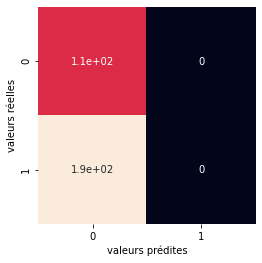

In [36]:
sns.heatmap(la_matrice, square=True, annot=True, cbar=False)         
        # , xticklabels=list(Y_test)
        # , yticklabels=list(Y_test))square=True, annot=True, cbar=False

plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles');

Sur les 300 billets, 107 ont été classés correctement. 193 n'ont pas été classés correctement. Ils ont été classés comme vrais billets alors qu'ils sont faux.

#### Accuracy, précision du modèle

In [37]:
print(metrics.classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.36      1.00      0.53       107
           1       0.00      0.00      0.00       193

    accuracy                           0.36       300
   macro avg       0.18      0.50      0.26       300
weighted avg       0.13      0.36      0.19       300



#### Interprétation du résultat de l'évaluation du modèle

Le modèle prédit 36 % de valeurs correctes.

Sur 107 billets de la classe 0, tous les billets ont été classés correctement. Sur les 193 billets de la classe 1, 193 n'ont pas été classés correctement.

Taux de précision pour la prédiction des vrais billets : 36%

Taux de précision pour la prédiction des faux billets :  0%

##  <a name="A3"> 3. Le clustering avec la regression logistique

La variable cible est is_genuine

##  <a name="C8"> 3.1. Préparation des données

#### Modifier le type de données de la variable is_genuine en variable catégorielle

In [38]:
dataBillets["is_genuine"] = dataBillets["is_genuine"].astype('category')

#### Copier le dataframe

In [39]:
data = dataBillets.copy()

#### Définir la variable cible et explicative

In [40]:
Y = data["is_genuine"].cat.codes
# on ne prend que les colonnes quantitatives
X = data[["diagonal","height_left", "height_right", "margin_low", "margin_up", "length" ]]

#### Split des données en bases de test et d'entrainement

In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
X_train

(1200, 6)
(300, 6)
(1200,)
(300,)


,diagonal,height_left,height_right,margin_low,margin_up,length
106,172.27,103.95,103.75,3.94,3.19,114.04
75,172.26,103.85,103.70,4.16,3.20,112.35
559,172.12,103.59,103.77,3.74,3.21,113.32
11,171.84,104.59,104.00,3.88,3.27,113.08
390,171.66,103.65,103.44,3.26,2.99,112.89
...,...,...,...,...,...,...
1424,171.68,103.90,104.41,4.74,3.29,111.85
1142,171.04,104.23,104.22,4.87,3.56,111.54
998,171.44,103.96,103.92,3.68,2.89,113.21
206,172.18,103.68,103.14,4.16,3.18,113.93


##  <a name="C9"> 3.2. Implémentation de la regression logistique sur la base train

#### Appliquer la ragression logistique par Statsmodel

In [42]:
x_stat = sm.add_constant(X_train)
# on ajuste le modèle
model = sm.Logit(Y_train, x_stat)
model_logistic = model.fit()
model_logistic.summary()

Optimization terminated successfully.
         Current function value: 0.026322
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1193
Method:                           MLE   Df Model:                            6
Date:                Thu, 01 Sep 2022   Pseudo R-squ.:                  0.9584
Time:                        12:17:59   Log-Likelihood:                -31.586
converged:                       True   LL-Null:                       -758.87
Covariance Type:            nonrobust   LLR p-value:                3.689e-311
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -191.1470    284.462     -0.672      0.502    -748.683     366.389
diagonal        -0.6440      1.276     -0.505      0.614      -3.145       1.857
height_left     -1.7000      1.223     -1.389      0.165      -4.098       0.698
height_right    -1.7406      1.125     -1.548      0.122      -3.945       0.464
margin_low      -6.3172      1.202     -5.254      0.000      -8.674      -3.961
margin_up      -10.6127      2.576     -4.119      0.000     -15.662      -5.563
length           6.4212      1.082      5.937      0.000       4.301       8.541
================================================================================

Possibly complete quasi-separation: A fraction 0.54 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Les variables height_left, diagonal,height_right et const ne sont pas significatives. La diagonal etant la moins significative des 3, nous commencerons par la supprimer en premier et redefinir notre modèle.

#### Suppression de la colonne diagonal non significative

In [43]:
data=data.drop(columns=['diagonal'])
data

,is_genuine,height_left,height_right,margin_low,margin_up,length,Individu
0,1,104.86,104.95,4.52,2.89,112.83,1
1,1,103.36,103.66,3.77,2.99,113.09,2
2,1,104.48,103.50,4.40,2.94,113.16,3
3,1,103.91,103.94,3.62,3.01,113.51,4
4,1,104.28,103.46,4.04,3.48,112.54,5
...,...,...,...,...,...,...,...
1495,0,104.38,104.17,4.42,3.09,111.28,1496
1496,0,104.63,104.44,5.27,3.37,110.97,1497
1497,0,104.01,104.12,5.51,3.36,111.95,1498
1498,0,104.28,104.06,5.17,3.46,112.25,1499


#### Redéfinition des variables

In [44]:
Y = data["is_genuine"].cat.codes
# on ne prend que les colonnes quantitatives
X = data[["height_right", "margin_low", "margin_up", "length", "height_left"]]

#### Split des données en bases test et d'entrainement

In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1200, 5)
(300, 5)
(1200,)
(300,)


#### Application de la regression logistique sur la base Train

In [46]:
x_stat = sm.add_constant(X_train)
# on ajuste le modèle
model = sm.Logit(Y_train, x_stat)
model_logistic=model.fit()
model_logistic.summary()

Optimization terminated successfully.
         Current function value: 0.026429
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1194
Method:                           MLE   Df Model:                            5
Date:                Thu, 01 Sep 2022   Pseudo R-squ.:                  0.9582
Time:                        12:17:59   Log-Likelihood:                -31.715
converged:                       True   LL-Null:                       -758.87
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -300.8876    186.926     -1.610      0.107    -667.255      65.480
height_right    -1.6542      1.121     -1.476      0.140      -3.851       0.543
margin_low      -6.1087      1.094     -5.583      0.000      -8.253      -3.964
margin_up      -10.5619      2.554     -4.135      0.000     -15.568      -5.556
length           6.3160      1.040      6.073      0.000       4.278       8.355
height_left     -1.6924      1.225     -1.381      0.167      -4.094       0.709
================================================================================

Possibly complete quasi-separation: A fraction 0.53 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Les variables height_right, height_left et la const ne sont pas significatives. La variable height_left étant la moins significative parmi les 3, nous la supprimerons en premier et continuerons à definir notre modèle.

#### Suppression de la variable height_left non significative

In [47]:
data=data.drop(columns=['height_left'])
data

,is_genuine,height_right,margin_low,margin_up,length,Individu
0,1,104.95,4.52,2.89,112.83,1
1,1,103.66,3.77,2.99,113.09,2
2,1,103.50,4.40,2.94,113.16,3
3,1,103.94,3.62,3.01,113.51,4
4,1,103.46,4.04,3.48,112.54,5
...,...,...,...,...,...,...
1495,0,104.17,4.42,3.09,111.28,1496
1496,0,104.44,5.27,3.37,110.97,1497
1497,0,104.12,5.51,3.36,111.95,1498
1498,0,104.06,5.17,3.46,112.25,1499


#### Redéfinition des variables

In [48]:
Y = data["is_genuine"].cat.codes
# on ne prend que les colonnes quantitatives
X = data[["margin_low", "margin_up", "length", "height_right"]]

#### Création des bases de test et d'entrainement

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1200, 4)
(300, 4)
(1200,)
(300,)


#### Appliquer la regression logistique sur la base Train

In [50]:
x_stat = sm.add_constant(X_train)
# on ajuste le modèle
model = sm.Logit(Y_train, X_train)
model_logistic = model.fit()
model_logistic.summary()

Optimization terminated successfully.
         Current function value: 0.030527
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1196
Method:                           MLE   Df Model:                            3
Date:                Thu, 01 Sep 2022   Pseudo R-squ.:                  0.9517
Time:                        12:17:59   Log-Likelihood:                -36.632
converged:                       True   LL-Null:                       -758.87
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
margin_low      -6.1028      1.031     -5.917      0.000      -8.124      -4.081
margin_up      -11.2487      2.325     -4.838      0.000     -15.805      -6.692
length           5.0595      0.714      7.087      0.000       3.660       6.459
height_right    -4.8597      0.732     -6.639      0.000      -6.295      -3.425
================================================================================

Possibly complete quasi-separation: A fraction 0.50 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Notre modèle explique 95,53% de la variation de notre variable dépendante is_genuine.

#### Prédiction de la classe sur les données Test (échantillon à valider) et les nouvelles données

In [51]:
Y_pred=model_logistic.predict(X_test)

prediction = list(map(round, Y_pred))

In [52]:
#x_stat = sm.add_constant(X_test)
# on ajuste le modèle
model = sm.Logit(Y_test, X_test)
model_logistic = model.fit()
model_logistic.summary()

Optimization terminated successfully.
         Current function value: 0.028172
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  300
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            3
Date:                Thu, 01 Sep 2022   Pseudo R-squ.:                  0.9568
Time:                        12:17:59   Log-Likelihood:                -8.4515
converged:                       True   LL-Null:                       -195.44
Covariance Type:            nonrobust   LLR p-value:                 9.555e-81
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
margin_low      -6.6896      2.308     -2.898      0.004     -11.213      -2.166
margin_up       -9.6770      4.812     -2.011      0.044     -19.109      -0.245
length           6.1356      1.980      3.099      0.002       2.255      10.016
height_right    -6.0397      2.017     -2.994      0.003      -9.994      -2.086
================================================================================

Possibly complete quasi-separation: A fraction 0.65 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

##  <a name="C10"> 3.3. Evaluation du modèle

#### Matrice de confusion 

In [53]:
la_matrice=confusion_matrix(Y_test,prediction)
print (la_matrice)

[[106   1]
 [  3 190]]


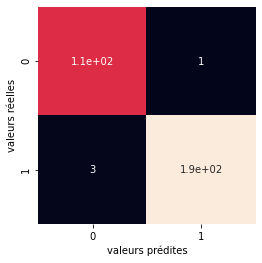

In [54]:
sns.heatmap(la_matrice, square=True, annot=True, cbar=False)         
        # , xticklabels=list(Y_test)
        # , yticklabels=list(Y_test))square=True, annot=True, cbar=False

plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles');

#### Précision et accurancy du modèle

In [55]:
metrics.f1_score(Y_test, prediction, average="macro") 

0.9855324074074074

In [56]:
print(metrics.classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       107
           1       0.99      0.98      0.99       193

    accuracy                           0.99       300
   macro avg       0.98      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



#### Interprétation du résultat

Le modèle prédit 98,56 % de valeurs correctes.

Sur 107 billets de la classe 0, 106 ont été classés correctement. 

Sur les 193 billets de la classe 1, 190 ont été classés correctement.

Taux de précision pour la prédiction des vrais billets : 97%

Taux de précision pour la prédiction des faux billets :  99%
    

Sur les 300 billets, 296 ont été classés correctement (106 vrais billets et 190 faux billets). 4 billets n'ont pas été classés correctement. 3 ont été classés comme vrais billets alors qu'ils sont faux et 1 classé comme faux billet alors qu'il est vrai billet.

Le modèle prédit 98 % de valeurs correctes.

##  <a name="A4"> 4. Modèle retenu

Le modèle issu du Kmeans prédit 36% % des valeurs correctes contre 98 % pour la regression logistique. Le modèle retenu est celui de la regression logistique car significatif.

##  <a name="A5"> 5. Application de détection de vrais et faux billets

#### Import du fichier à tester

In [57]:
billets_prod = pd.read_csv('C:/Users/33768/Documents/DataSets/Projet 10/billets.csv', sep=';',encoding='UTF-8')
#billets_prod = pd.read_csv('C:/Users/33768/Documents/DataSets/Projet 10/billets_production.csv', sep=',',encoding='UTF-8')
print("Aperçu du fichier à tester")
display(billets_prod.head())

Aperçu du fichier à tester


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


#### Implémentation de la fonction test

In [58]:
def detectBillets(data):
    
    # Préparation de données 
    X = data[["margin_low", "margin_up", "length", "height_right"]]
    X_na = data[['length','margin_up','height_right','height_left']]
    
    #Imputation des valeurs 
    X["margin_low"][X["margin_low"].isnull()] = model_reg_multi.predict(X_na)
    # Standardisation des données
    #X_scaled = preprocessing.StandardScaler().fit_transform(X)
    X['Prediction'] = model_logistic.predict(X)
    X['Prediction'] = list(map(round, X['Prediction']))
 
    X["Nature_billet"] = X["Prediction"].copy()
    X["Nature_billet"].replace([0,1],["Faux billet", "Vrai billet"], inplace=True)
        
    print('\033[1m' + "Nombre total de billets : " +  '\033[0m',len(X))
    print('\033[1m' + "Nombre de billets authentiques : " +  '\033[0m',len(X[X["Prediction"]== 1]))
    print('\033[1m' + "Nombre de faux billets : " +  '\033[0m',len(X[X["Prediction"]== 0]), "\n")
    display(X)
    # Vérifier que les lignes avec valeurs manquantes ont été supprimées du dataframe
    print(X.isna().sum())
 
    labels=["Faux billet", "Vrai billet"]
    sns.countplot(x="Nature_billet", data=X, palette=["darkslategrey","bisque"])
    plt.show()

#### Résultat 

Nombre total de billets :  1500
Nombre de billets authentiques :  1007
Nombre de faux billets :  493 



,margin_low,margin_up,length,height_right,Prediction,Nature_billet
0,4.52,2.89,112.83,104.95,1,Vrai billet
1,3.77,2.99,113.09,103.66,1,Vrai billet
2,4.40,2.94,113.16,103.50,1,Vrai billet
3,3.62,3.01,113.51,103.94,1,Vrai billet
4,4.04,3.48,112.54,103.46,1,Vrai billet
...,...,...,...,...,...,...
1495,4.42,3.09,111.28,104.17,0,Faux billet
1496,5.27,3.37,110.97,104.44,0,Faux billet
1497,5.51,3.36,111.95,104.12,0,Faux billet
1498,5.17,3.46,112.25,104.06,0,Faux billet


margin_low       0
margin_up        0
length           0
height_right     0
Prediction       0
Nature_billet    0
dtype: int64


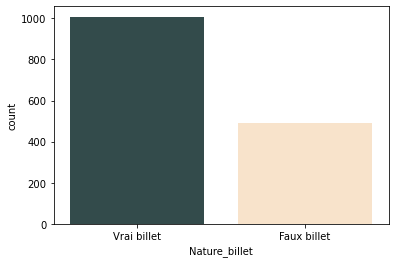

In [59]:
detectBillets(billets_prod)